In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [5]:
class ParentState(TypedDict):

    question: str
    answer_eng: str
    answer_hin: str
    

In [6]:
parent_llm = ChatOpenAI(model='gpt-4o-mini')
subgraph_llm = ChatOpenAI(model='gpt-4o')

In [14]:
def translate_text(state: ParentState):

    prompt = f"""
Translate the following text to Hindi.
Keep it natural and clear. Do not add extra content.

Text:
{state["answer_eng"]}
""".strip()
    
    translated_text = subgraph_llm.invoke(prompt).content

    return {'answer_hin': translated_text}

In [15]:
subgraph_builder = StateGraph(ParentState)

subgraph_builder.add_node('translate_text', translate_text)

subgraph_builder.add_edge(START, 'translate_text')
subgraph_builder.add_edge('translate_text', END)

subgraph = subgraph_builder.compile()

In [16]:
def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [17]:
parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", subgraph)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

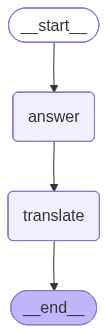

In [18]:
graph = parent_builder.compile()

graph

In [19]:
graph.invoke({'question': 'What is quantum physics'})

{'question': 'What is quantum physics',
 'answer_eng': "Quantum physics, also known as quantum mechanics, is a fundamental branch of physics that deals with the behavior of matter and energy at very small scales, typically at the level of atoms and subatomic particles. It fundamentally challenges classical physics concepts by introducing principles such as:\n\n1. **Wave-Particle Duality**: Particles like electrons exhibit both wave-like and particle-like properties. This means they can behave like waves in some experiments and like particles in others.\n\n2. **Quantization of Energy**: Energy is not continuous but quantized, meaning it exists in discrete packets called quanta. For example, light travels in packets known as photons.\n\n3. **Uncertainty Principle**: Formulated by Werner Heisenberg, this principle states that there is a fundamental limit to the precision with which certain pairs of physical properties (like position and momentum) can be known simultaneously.\n\n4. **Super